<img src="images/Logo_UCLL_ENG_RGB.png" style="background-color:white;" />

# Data & Artificial Intelligence

Lecturer: Jan D'Espallier

Inspired (a.o) by: lecture from Chidi Nweke 2022-2023 & Keras tutorials

Academic year 2025-2026

***Computer Vision , Convolutional networks***

Our goal for this class is that by the end of it you 

- Will have a feeling of how computer vision was done in the past. Engineered feature extraction, used (for example) in image classification.

- Will understand the power of CNN and you will be able to read a diagram like the one below. Also you should be able to design and train one to use it for image recognition tasks.

<center><img src="images/cnn architecture.webp" style="background-color:white; max-width:50%"/></center>

- Will understand that these days you do not have to design and train your own cnn architecture anymore. Instead you better reuse pre-designed/trained networks, and fine tune them for your application.

## How this notebook works..
In this notebook you'll find cells that start with a ❓. These cells contain a question or a task.
Insert an extra cell after these and either formulate an answer or fill in some code.
After the workshop you'll get the fully completed notebook, such that you can use it @home to see potential solutions.

## Getting your environment ready
This notebook has been tested in an anaconda environment on windows with python 3.11.9 installed.

It should run as well on Linux and or with other versions of python as long as the correct packages have been installed.
pip install -r requirements should do the job

Installing the packages manually is also an option.
 - pip install matplotlib
 - pip install scikit-learn
 - pip install seaborn
 - pip install opencv-python
 - pip install tensorflow
 - pip install tensorflow-datasets
 - pip install notebook
  

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import numpy as np
import cv2 as cv

2025-10-19 22:24:54.738630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-19 22:24:55.433879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 22:24:58.111034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Previous course
This notebook is a following the one on neural networks. It is advised that you first run trough that notebook to get a good understanding of some basic concepts which are reused in this notebook.
The following 3 functions are also copy/pasted from that notebook.

In [2]:
def plotTrainingHistory(history):
    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjusted figsize to better fit two subplots
    
    # Plot training and validation loss on the first subplot
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy on the second subplot
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Improve layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [3]:
def displayPerformanceFigures(real,pred,title,includeCF=True):
   if includeCF:
       # Compute confusion matrix
       cm = confusion_matrix(real, pred)
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
       plt.xlabel('Predicted labels')
       plt.ylabel('True labels')
       plt.title('Confusion Matrix for '+title+' samples')
       plt.show() 

   acc= accuracy_score(real, pred)
   print("Accuracy: ", acc)
    
   f1 = f1_score(real, pred, average='macro')
   print("F1 Score: ", f1)

In [4]:
def compile_and_train_model_then_evaluate_its_performance(mod,x_train,y_train,x_val,y_val,epochs_to_train,batch_s):
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # If the validation loss rises for 3 epochs training is stopped
    history = mod.fit(x_train, y_train, epochs=epochs_to_train, batch_size=batch_s, validation_data=(x_val, y_val), callbacks=callback)
    plotTrainingHistory(history)

    y_val_pred=np.argmax(mod.predict(x_val),axis=1)
    displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)

## The dataset(s)

Configure here, which data set you actually want to use. In theory the notebook should work with both following db's
- [flower db](https://www.tensorflow.org/datasets/catalog/tf_flowers) 3670 colour images of 5 classes of flowers in different sizes/resolutions.
- [cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) 60000 32x32 (only) colour images in 10 classes, with 6000 images per class

Latest developments all have been executed using the cifar-10 db.

In [5]:
db_2_use='flowers'
#db_2_use='cifar-10'

### Flowers

In [6]:
if db_2_use=='flowers' :
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
    data_dir = pathlib.Path(data_dir)
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print(image_count)

3670


In [7]:
print(data_dir)

/home/user/.keras/datasets/flower_photos


In [8]:
if db_2_use=='flowers' :
    def dataset_to_numpy_ints(dataset):
        x = []
        y = []
    
        # Iterate through the dataset
        for image, label in dataset:
            # Rescale images from [0, 1] to [0, 255] and convert to uint8
            # SIFT requires uint8 values. (it is also the format of the images in the cifar-db)
            image_uint8 = (image.numpy() ).astype(np.uint8)
            #image_uint8 = (image.numpy() * 255).astype(np.uint8)
            x.append(image_uint8)  # Append the converted images
            y.append(label)  # Append labels directly
        x = np.concatenate(x, axis=0)
        y = np.concatenate(y, axis=0)
        return x, y

In [11]:
if db_2_use=='flowers' :
    # the images have different sizes. Neural nets require always the same input size for each sample.
    # so we will rescale all img's
    img_height = 224 
    img_width = 224
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      )

    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      )

    class_names = train_ds.class_names

    # we want to reformat our data from 'data sets' to 'arrays'
    # at the same moment we also rescale the flower images to 0->256 (such that we have the same format for cifar-10 as for the flowers)
    x_train, y_train = dataset_to_numpy_ints(train_ds)
    x_val, y_val     = dataset_to_numpy_ints(val_ds)

Found 7340 files belonging to 6 classes.
Using 5872 files for training.
Found 7340 files belonging to 6 classes.
Using 1468 files for validation.


2025-10-19 22:46:18.544963: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Data general

In [10]:
num_classes=len(class_names)

❓ 1 Inspection of our data
- How many training samples dow we have? 
- How many validation samples? 
- What is the resolution of our images?
- How which classes do we have in our dataset? 

In [12]:
print(f'Num of training samples: {len(x_train)}')
print(f'Num of validation samples: {len(x_val)}')
print(f'resolution of images: {x_train[0].shape[0:2]}')
print(f'Classes: {train_ds.class_names}')

Num of training samples: 5872
Num of validation samples: 1468
resolution of images: (224, 224)
Classes: ['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']


In [24]:
# what is the range of the pixel values in this db?
max_value = np.amax(x_train)
min_value = np.amin(x_train)
print("Maximum value:", max_value)
print("Minimum value:", min_value)
scale=max_value # the scale that will be used to normalise the data before the data is fed into the network

Maximum value: 255
Minimum value: 0


 ❓2 Visual inspection of some samples
 
 PLot the first (10?) samples from the training set.
 You can use plt.imshow() to do that. Ideally you also plot the classname of the sample in the title or alike. 

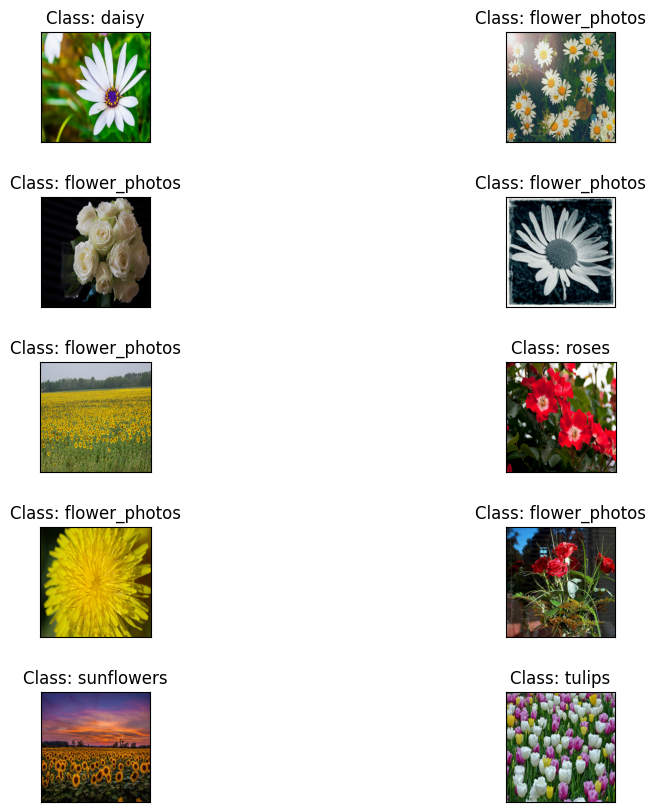

In [13]:
fig, axes = plt.subplots(5,2,figsize=(10,10))

fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    
    # Title with the corresponding digit
    if isinstance(class_names, list):
        title = class_names[y_train[i]] if y_train[i] < len(class_names) else str(y_train[i])
    else:
        title = str(y_train[i])
    ax.set_title(f"Class: {title}")
    
    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()

## Engineered features : e.g. SIFT

In the theoretical session on CNN and image classification we touched briefly SIFT feature extraction & matching.
SIFT was an engineered way to extract features which could be used to classify images, or to look for matching images.
SIFT finds the spots in an image that stay recognizable even if you zoom, rotate, or change lighting — the most stable details.
It  detects key points where texture or contrast changes sharply, making them easy for a computer to ‘recognize’ again.

### Object detection or Image comparison

SIFT features work well for matching objects in different pictures...as long as the spatial relation between the recognised features remains the same in both images. To make SIFT extraction tangible , we first extract SIFT features from 2 pictures (grayscale), then we try to 'match' both feature sets on each other...and display the best matches.

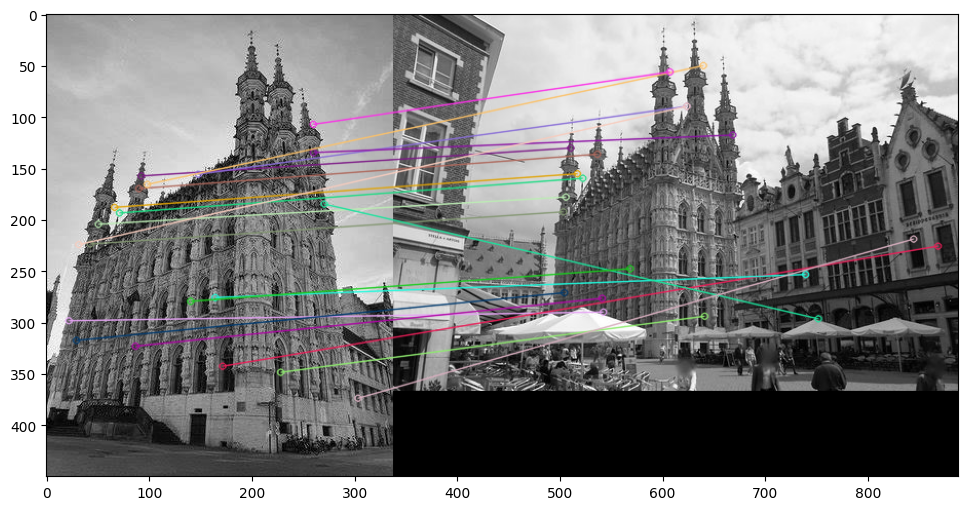

In [27]:
# Load images
img1 = cv.imread('images/stadhuis_leuven_1.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('images/stadhuis_leuven_2.jpg', cv.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.80 * n.distance:
        good_matches.append(m)

# Sort matches by distance
good_matches = sorted(good_matches, key=lambda x: x.distance)

# Draw top 10 matches
img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:20], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot images side by side with matched features connected
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(img_matches)
plt.show()

❓3 Any observation ?

the result has some errors 

### Image classification(?)

In class, it was explained that SIFT can caracterise well a 'specific' object in a specific positions. (Buildings typically will always have the same position. But that does not hold for living creatures (persosn/cats). SIFT will also charcaterise a'specif' instance of a class...itt will much less characterise 'all instances of a class'. Therefore we do not expect to sift to work well for a classification task. Let's try to train a classifier using SIFT features anyway...
We will use the flowers or cifar db we initialised before for this experiment.

In [28]:
sift = cv.SIFT_create(nfeatures=50)

In [29]:
def extract_sift_features(images,engine):
    sift_features = []
    for img in images:
        # Convert image to grayscale
        gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        
        # Detect and compute SIFT features
        kp, des = engine.detectAndCompute(gray_img, None)
        
        # If no keypoints found, set SIFT feature vector to zeros
        if des is None:
            des = np.zeros((50, 128))
        else:
            # Pad SIFT descriptors to ensure fixed length (50)
            if des.shape[0] < 50:
                des = np.concatenate((des, np.zeros((50 - des.shape[0], 128))), axis=0)
            elif des.shape[0] > 50:
                des = des[:50, :]
        
        # Append SIFT feature descriptor to list
        sift_features.append(des)
    
    return np.array(sift_features)

# Extract SIFT features for training and validation images
x_train_sift = extract_sift_features(x_train,sift)
x_val_sift = extract_sift_features(x_val,sift)

Lets compare the size of our input samples, with the size of our sift features

In [30]:
x_train[0].shape

(224, 224, 3)

In [31]:
x_train_sift[0].shape

(50, 128)

In [32]:
classifier_for_sift = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(50, 128)), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2095 - loss: 32.0151 - val_accuracy: 0.2112 - val_loss: 13.0576
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2095 - loss: 32.0151 - val_accuracy: 0.2112 - val_loss: 13.0576
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2592 - loss: 9.5539 - val_accuracy: 0.2452 - val_loss: 8.3032
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2592 - loss: 9.5539 - val_accuracy: 0.2452 - val_loss: 8.3032
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2803 - loss: 6.7213 - val_accuracy: 0.2616 - val_loss: 6.8508
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2803 - loss: 6.7213 - val_accuracy: 0.2616 - val_loss: 6.8508
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3246 - loss: 5.3144 - val_accuracy: 0.3052 - val_loss: 6.1528
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3246 - loss: 5.3144 - val_accuracy: 0.3052 - val

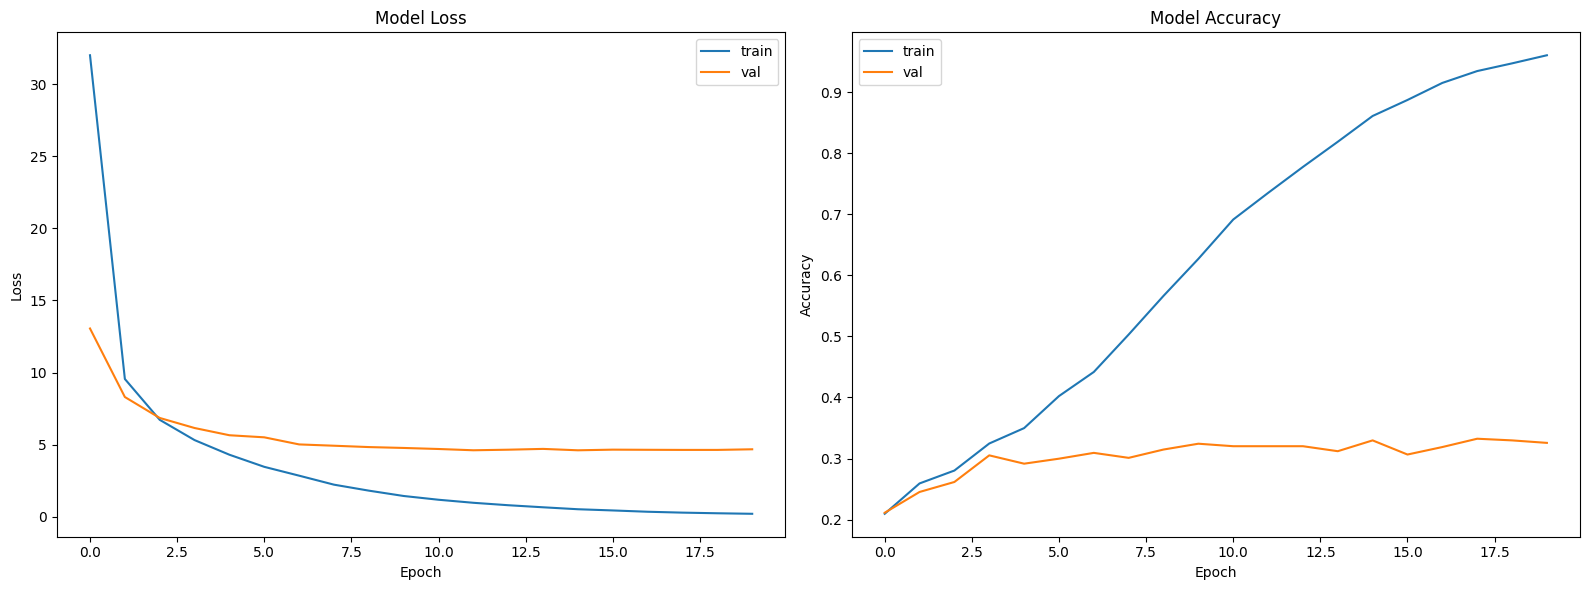

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


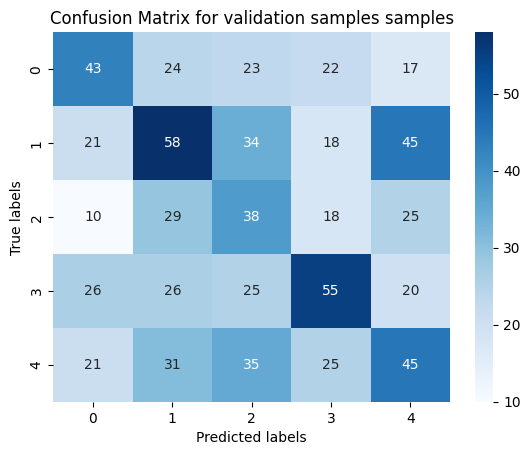

Accuracy:  0.32561307901907355
F1 Score:  0.3256290838878268


In [33]:
compile_and_train_model_then_evaluate_its_performance(classifier_for_sift,x_train_sift,y_train,x_val_sift,y_val,25,256)

❓4 Does this work ?

Not really.

## Self made convolutional neural networks

Convolutional networks, start from the same principle. First extract features, then classify the features.
The big difference with handcrafted/engineered features is that CNN's can find themselves (using a special type of neural nets) which feature set is most performant to do the classification job at hand. You no longer have to handcraft(potentially using tools) the features your self :-)

<center><img src="images/cnn.ppm" style="background-color:white; max-width:50%"/></center>

Convolutional neural networks, also known as CNN's, learn the values for the filters in the network.

The following snippet:

```Python

import tensorflow as tf

convLayers = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same"),
])
```

Shows the basic building block of a CNN : the Conv2D layer.

Lets assume our input image has a resolution 224x224x3.

This neural network has 3 layers. 

The first one is a convolution layer that contains 256 filters. Each of this filter scans the entire image. Each filter is of size 3x3x3 (because we have 3 color channels). ```padding="same"``` means that after applying the convolution we want our output image to be the same size. **After applying this convolution our image size is 224x224x256.** 256 **unique** filters scanned through your image and thus **produced 256 (gray_scale) variations of your input image.** (you also could say that your 3 channel image got transformed in an image with 256 cahnnels ) 

The second layer has 128 filters. Each of these scans the image again. These filters are of size 3x3x128. The ouput here is 250x250x128, 128 unique filters scanned the image.
   
A final convolution layer scans the image. The **feature map**'s size is 32 here. 32 features are considered.

#### Feature Extraction
Features refer to the learned weights of the filters in the convolutional layers. These weights determine what patterns the filters are looking for in the input image.

**Each filter is looking for different features.** Some of them are looking for vertical lines, others horizontal lines, etc. 

Feature activations (or feature maps) are the outputs of a convolutional layer after the image has been processed by the filters. These activations represent the response of each filter to different regions of the input image, highlighting different aspects of the original image.

In summary, through successive layers of convolutions, CNNs transform the input image into a series of feature maps, each highlighting different aspects of the original image, ultimately allowing the network to recognize and interpret the high-level features in the image.

<center><img src="images/conv layer features.png" style="background-color:white; max-width:50%"/></center>

In [35]:
x_res=224               # in cifar-10 it would be 32
y_res=224               # in cifar-10 it would be 32
chans=3                 # color
imaginary_nb_of_imgs=64 # does not matter. It is only used to build a fake/random batch of
                        # input imgs to allow us to inspect the architecture of our model.

color_imgs = np.random.rand(imaginary_nb_of_imgs,x_res,y_res,chans)

l1  = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same',activation='relu')
ol1 = l1(color_imgs)
print('layer 1 output:',ol1.shape)
weights_l1, biases_l1 = l1.get_weights()
print('layer 1 kernel size:',weights_l1.shape)
print()

l2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='relu')
ol2=l2(ol1)
print('layer 2 output:',ol2.shape)
weights_l2, biases_l2 = l2.get_weights()
print('layer 2 kernel size:',weights_l2.shape)
print()

l3=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu')
features=l3(ol2)
print('layer 3 output:',features.shape)
weights_l3, biases_l3 = l3.get_weights()
print('layer 3 kernel size:',weights_l3.shape)

layer 1 output: (64, 224, 224, 256)
layer 1 kernel size: (3, 3, 3, 256)

layer 2 output: (64, 224, 224, 128)
layer 2 kernel size: (3, 3, 256, 128)

layer 3 output: (64, 224, 224, 32)
layer 3 kernel size: (3, 3, 128, 32)


Look at the actual kernel size......for layer 1 it is not 3x3 as specified but 3x3x3 (and then 256 kernels). For layer 2 its 3x3x256 (and tyen 128 kernels), etc..
This is because in Keras, each kernel works on 3 different channels to create a single Dimensional output.  

❓ 5 What do we still need extra in the network before we can call it it classifier model?

classifying layers

In [36]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_width, img_height,3)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

❓ 6 What do the last 4 layers do?

flatten: turn 2d dimensional data into 1d. Dense layers are used to train features and apply activation functions. The softmax function summarizes all the outputs to 1 output.

❓ 7 How big is this network?
Use the .summary() method to investigate the number of parameters to train this network.
What do you notice?

In [37]:
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1605632)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │   205,521,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,864,421 (785.31 MB)

 Trainable params: 205,864,421 (785.31 MB)

 Non-trainable params: 0 (0.00 B)

The most parameters are in the first dense layer and the conv layers do not have as much parameters

We need one last ingredient to make a convolutional neural network: **pooling**. The point of pooling is to downsample, it more specifically reduces the size of the images. This makes neural networks more invariant to translation (shifting an image to the left/right/up/down), makes it more computationally efficient to train (less parameters) and generally seem to improve performance.
 
<center><img src="images/pooling1.png" style="background-color:white; max-width:50%"/></center>

<center><img src="images/pooling2.png" style="background-color:white; max-width:50%"/></center>

#### Building the network

Note that we also better normalise the pixel values before feeding them to the network. So we add a rescaling layer.

For info on the layers used see : keras manuals
 - rescaling [see here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling)
 - conv2D [see here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
 - maxPooling2D [see here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
 - model.fit|predict [see](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [38]:
my_kernel_size=3
layer_filters=[256,128,32]
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(img_width, img_height,3)),
  
  tf.keras.layers.Rescaling(1./scale, offset=-1),

  tf.keras.layers.Conv2D(filters=layer_filters[0],kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'), 
    

  tf.keras.layers.Conv2D(filters=layer_filters[1], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),
  
  tf.keras.layers.Conv2D(filters=layer_filters[2], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  #tf.keras.layers.Dense(num_classes)
  tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

❓8 Look again at the archticture and size of the network. What happened to the amount of trainable parameters?

In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,559,077 (13.58 MB)

 Trainable params: 3,559,077 (13.58 MB)

 Non-trainable params: 0 (0.00 B)

The number of params decreased drastically

Let's go ahead and train the classifier.
Note that we first lower the number of kernels used significantly to make training a feasible task for your machine.

In [41]:
tf.random.set_seed(42)  # to ensure cponsistent initialisation of th weigths  
my_kernel_size=3

layer_filters=[64,32,16] # when working with cifar-10 ...this one 
#layer_filters=[128,64,32] # when working with flowers....this one will be more feasible
#layer_filters=[256,128,32] # this combination was used above in the pre-lude

model = tf.keras.Sequential([
  
  tf.keras.layers.Input(shape=(img_width, img_height,3)),

  tf.keras.layers.Rescaling(1./scale, offset=-1),

  tf.keras.layers.Conv2D(filters=layer_filters[0],kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'), 
    

  tf.keras.layers.Conv2D(filters=layer_filters[1], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),
  
  tf.keras.layers.Conv2D(filters=layer_filters[2], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,221 (6.25 MB)

 Trainable params: 1,639,221 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
epochs_to_train=25

In [43]:
batch_size = 64

In [44]:
cnn_weigths_file="cnn_classifier_"+db_2_use+"_ep_"+str(epochs_to_train)+'_'+str(layer_filters)+".weights.h5"
cnn_weigths_file

'cnn_classifier_flowers_ep_25_[64, 32, 16].weights.h5'

Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.3668 - loss: 1.4358 - val_accuracy: 0.4646 - val_loss: 1.2795
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.5518 - loss: 1.1245 - val_accuracy: 0.5531 - val_loss: 1.1041
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.6226 - loss: 0.9975 - val_accuracy: 0.5804 - val_loss: 1.0370
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.6536 - loss: 0.9184 - val_accuracy: 0.6213 - val_loss: 0.9707
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.6832 - loss: 0.8474 - val_accuracy: 0.6335 - val_loss: 0.9565
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.7115 - loss: 0.7615 - val_accuracy: 0.6253 - val_loss: 0.9674
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - accuracy: 0.7514 - loss: 0.6714 - val_accuracy: 0.6308 - val_loss: 0.9668
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.7854 - loss: 0.5855 - val_accu

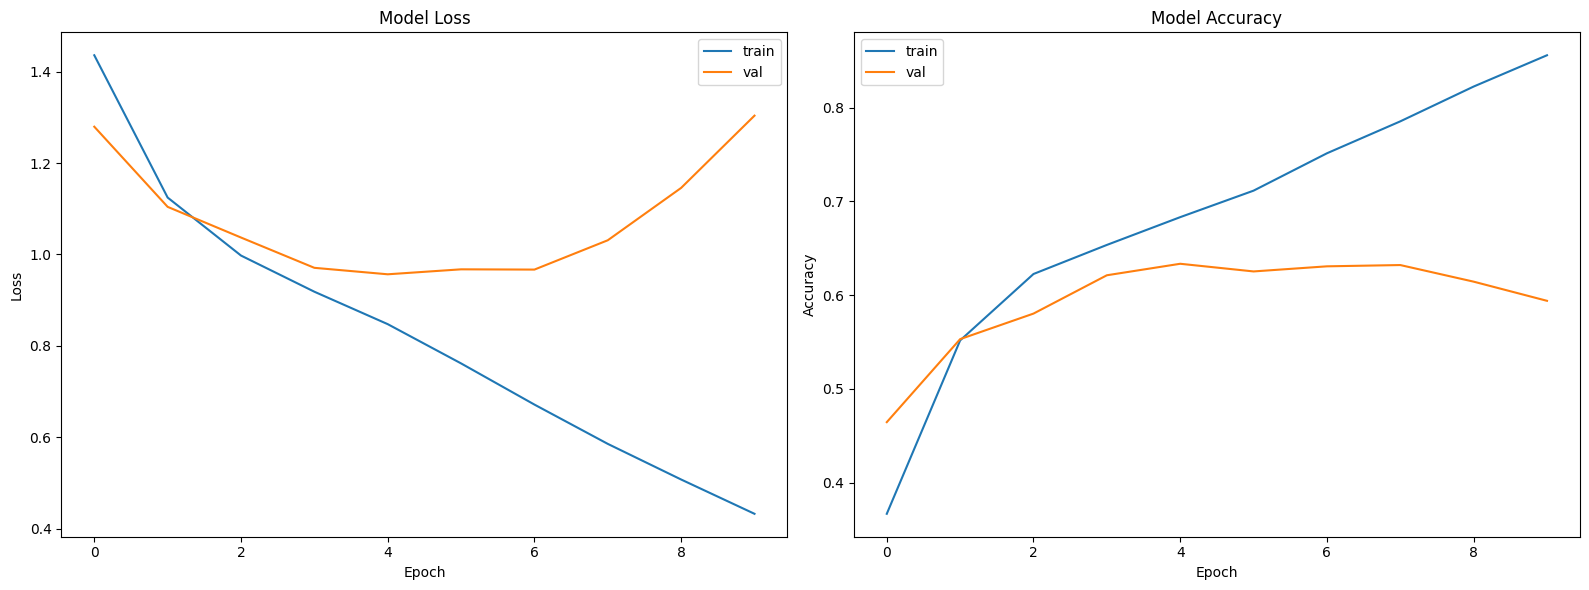

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


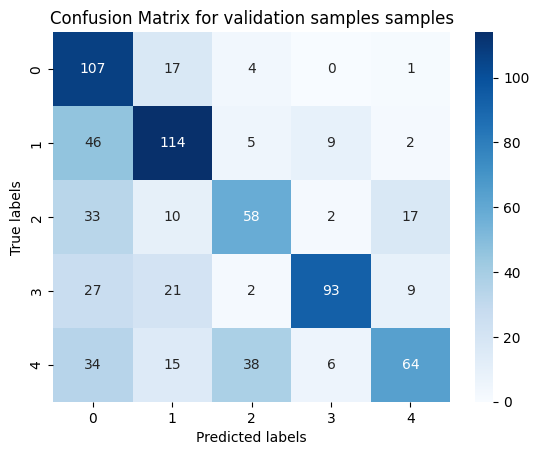

Accuracy:  0.5940054495912807
F1 Score:  0.5895956334852337


In [45]:
#load_or_train_weights='load' (in case you have trained this model before & saved the weights)
load_or_train_weights='train'
if load_or_train_weights=='load':
    model.load_weights(cnn_weigths_file, skip_mismatch=False)
    y_val_pred=np.argmax(model.predict(x_val),axis=1)
    displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)
else:    
    compile_and_train_model_then_evaluate_its_performance(model,x_train,y_train,x_val,y_val,epochs_to_train,batch_size)

❓ 9 Write in a few lines your impression about the performance.

The model performs better than CIFR. It overfits after 5th epoch



Note 2: As we see overfitting, we could try to
- insert drop out layers..or
- apply L2 regularisation (or weigth decay)
- use more data (in case of cifar10)
- ...

In [46]:
save_model_weights=True
if save_model_weights :
   model.save_weights(cnn_weigths_file, overwrite=True)

Let's test our model on a truly yet unseen image. ( The validation data have not been used for fitting the network...but they have been used to e.g deciding when to stop training....so somehow they already had an influence on the weigths we use.

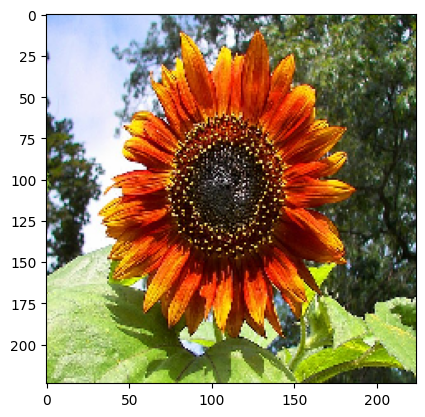

In [47]:
if db_2_use=='flowers' :
#    test_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#    test_path = tf.keras.utils.get_file('Red_sunflower', origin=test_url)
    test_path="./data/sunflower.jpg"
if db_2_use=='cifar-10' :
    test_path="./data/car.jpg"

# load image into PIL format
img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img)

In [48]:
# convert the PIL image to an array 
img_array=np.array(img)

In [49]:
img_array.shape

(224, 224, 3)

In [50]:
img_array = tf.expand_dims(img_array, 0) # Create a batch of 1 input. ( model.predict runs on a 'set' of images)
img_array.shape

TensorShape([1, 224, 224, 3])

In [51]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image most likely belongs to roses with a 34.02 percent confidence.


## Transfer learning

Do we need to design a new neural network architecture for each task? Do we need to retrain everytime a neural net from scratch?
A lot of research has been done about this in the past. 
https://keras.io/api/applications/ provides several neural networks we can download and use.

The models in keras applications were trained on a dataset called imagenet that contains millions of samples and 1000 distinct classes. The convolutional layers are quite general. **This is the key way to train and use very deep neural networks if you don't have a lot of data.** The only thing you are training in this case are the Dense layers. This is a far easier task.

To demonstrate this we'll use the state of the art anno 2020 for image classification (called Xception). For this architecture you do not need to understand the diagram whatsoever, it is just indicative of the fact that it is significantly more complicated to come up with yourself and implement.

<center> Xception, VGG and Resnet </center>
<center><img src="images/xception.ppm" style="background-color:white"/></center>

### Xception

We can import a model and then use existing, trained convolutional layers. Since these layers essentially learn features it can be said that the features learnt for one task (e.g., categorizing dogs vs cats) can generalize towards other tasks. **This is called transfer learning.** This will be a key technique applied in the experiment below.

We will use XCeption as base model. XCeption needs 96x96 as input...so we will need to scale up our cifar-10 images.

In [52]:
seed=54
np.random.seed(seed)
tf.random.set_seed(seed)

In [53]:
# note : xception needs input at least 71x71. If smaller -> the pooling will squeeze the images to much...
if db_2_use=='flowers' :
    # no reacaling needed
    new_size=224
    x_train_resized=x_train
    x_val_resized=x_val
if db_2_use=='cifar-10' :
    new_size=96
    
    x_train_resized = np.zeros((len(x_train), new_size, new_size, 3), dtype=np.uint8)
    for i in range(len(x_train)):
        x_train_resized[i] = cv.resize(x_train[i], (new_size, new_size))

    x_val_resized = np.zeros((len(x_val), new_size, new_size, 3), dtype=np.uint8)
    for i in range(len(x_val)):
        x_val_resized[i] = cv.resize(x_val[i], (new_size,new_size))

In [54]:
xc_base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(new_size,new_size,3), pooling="max") # Include top means we don't take any dense layers. 
xc_base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


The basemodel (without the top layers) generates features. To turn the basemodel into a classifier, we will preceed it with a rescaler add a few classic dense layers (possibly followed by drop out layers) and a last dense layer with a softmax activation. So in fact we replace the standard top layers with our own clasifier layers.
The weigths of this last layer will still need to be trained.

In [55]:
def make_classifier_model(base,classifier_layer_sizes,num_classes):
   model = tf.keras.Sequential()
   model.add(tf.keras.layers.Rescaling(1./scale, offset=-1))
   model.add(base),

   for size in classifier_layer_sizes :
       model.add(tf.keras.layers.Dense(size, activation='relu'))
       model.add(tf.keras.layers.Dropout(0.2))

   model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
   return model

In [56]:
#layers_2_use=[64,32,16]
layers_2_use=[32,16]

In [57]:
xception_classifier=make_classifier_model(xc_base_model,layers_2_use,num_classes)

xception_classifier.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

xception_classifier.build(input_shape=(None,new_size,new_size,3))
xception_classifier.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,927,661 (79.83 MB)

 Trainable params: 66,181 (258.52 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

❓10 What can you remark about the amount of trainable parameters?

There are significantly less trainable params than we seen before

In [ ]:
Those who want can try to out comment the line base_model.trainable = False and look at the # of trainable params in that case...(do not forget to undo this change before training the net).

In [61]:
epochs_to_train=25
xception_weigths_file="./weigths/xception_classifier_"+db_2_use+"_ep_"+str(epochs_to_train)+"_layers_"+str(layers_2_use)+"_seed_"+str(seed)+".weights.h5"
xception_weigths_file

'./weigths/xception_classifier_flowers_ep_25_layers_[32, 16]_seed_54.weights.h5'

❓ 11 Fit the model (incl. early stopping) for 25? epochs and plot the training history
tip : use 'restore_best_weights=True' in the early stopping callback. In this way , you will end up with the 'best' model iso the last one.

In [65]:
load_or_train_weights='load'
#load_or_train_weights='train'
if load_or_train_weights=='load':
    xception_classifier.load_weights(xception_weigths_file, skip_mismatch=False)
else: 
    history=xception_classifier.fit(...)
    plotTrainingHistory(history)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'weigths\xception_classifier_flowers_ep_25_layers_[32, 16]_seed_54.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4309 - loss: 1.4271 - val_accuracy: 0.7248 - val_loss: 0.8928
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6155 - loss: 0.9777 - val_accuracy: 0.7984 - val_loss: 0.6647
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6792 - loss: 0.8298 - val_accuracy: 0.8338 - val_loss: 0.5588
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7204 - loss: 0.7428 - val_accuracy: 0.8447 - val_loss: 0.5100
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.7435 - loss: 0.6865 - val_accuracy: 0.8529 - val_loss: 0.4733
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7681 - loss: 0.6057 - val_accuracy: 0.8624 - val_loss: 0.4381
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 272s 6s/step - accuracy: 0.7820 - loss: 0.5706 - val_accuracy: 0.8706 - val_loss: 0.4147
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.7926 - loss: 0.5364 - val_accuracy: 0.8651 - val_

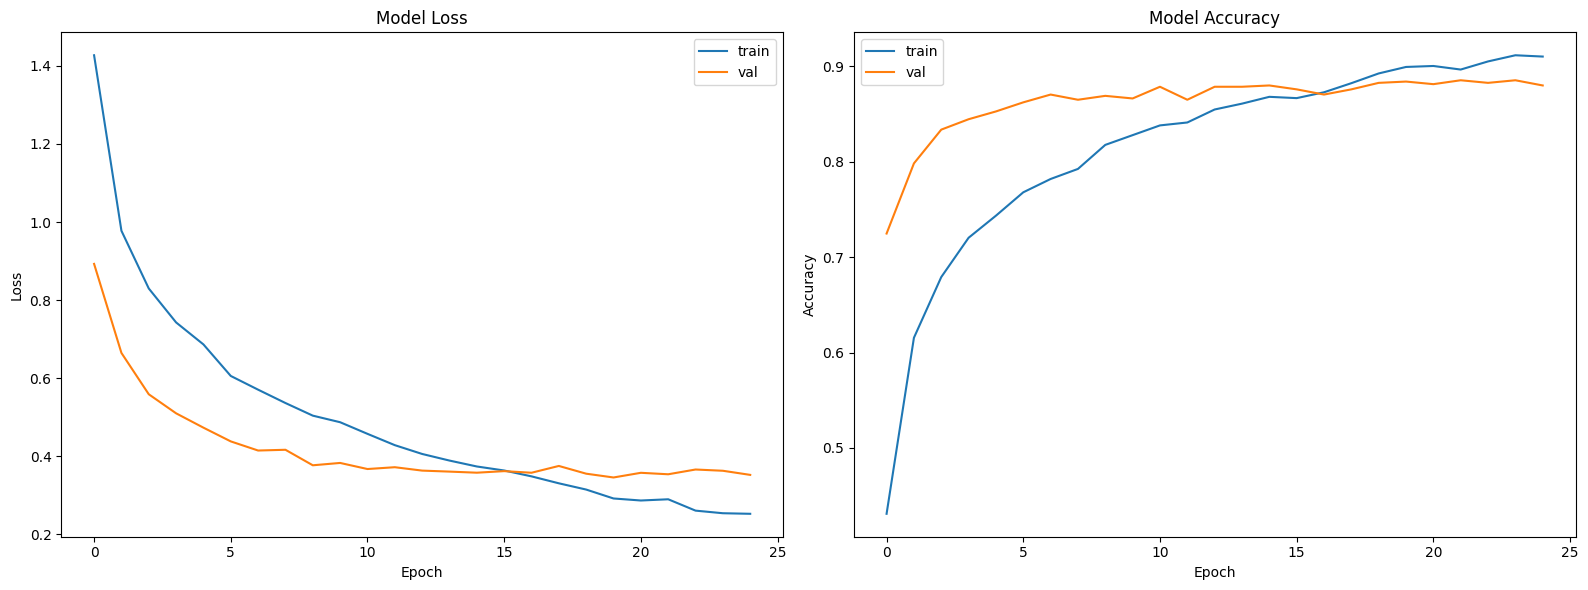

In [66]:
load_or_train_weights='train'
#load_or_train_weights='load'
if load_or_train_weights=='load':
    xception_classifier.load_weights(xception_weigths_file, skip_mismatch=False)
else: 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = xception_classifier.fit(x_train_resized, y_train, epochs=epochs_to_train, batch_size=batch_size, validation_data=(x_val_resized, y_val), callbacks=[callback])
    plotTrainingHistory(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 582ms/step


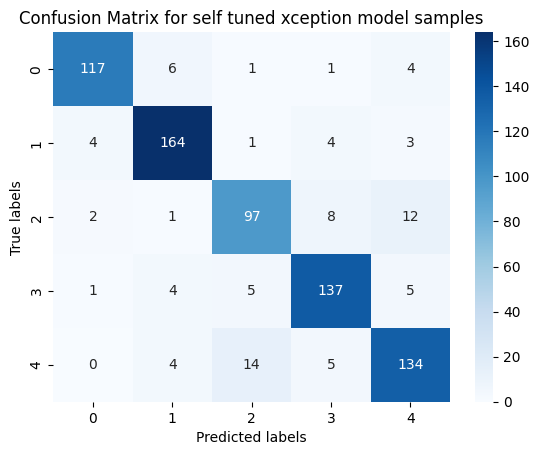

Accuracy:  0.8841961852861036
F1 Score:  0.8814545384557754


In [67]:
# Predict the probabilities across all classes
predictions = xception_classifier.predict(x_val_resized)
# Select the prediction with the highest probability.
y_val_pred  = np.argmax(predictions, axis=1)
displayPerformanceFigures(y_val,y_val_pred,'self tuned xception model',includeCF=True)

❓12 What is the accuracy you reached?
Is it more performant than our self designed/trained CNN model ? 

Accuracy:  0.8841961852861036
Yes it is more performant. 

In case you do not manage to train the network yourself : this was the result I got after training for 25 epochs on the cifar-10 db [32 16]  layers with 0.2 dropout, an f1 of 0,74.
<center><img src="images/training history xception cifar10 25 epochs 32 16 seed 54 dropout 0_2.jpg" style="background-color:white; max-width:50%"/></center>

For the flowers db and [32 16] layers, seed :54 : I reached, an f1 of 0.87 for the validation data.
<center><img src="images/training history xception flowers 25 epochs 32 16 seed 54 dropout 0_2.jpg" style="background-color:white; max-width:50%"/></center>

Note: we still see overfitting. If you have time you can 
- increase the drop out rate
- reduce further the compexity of our classifier layers
- play with the 'batch_size' (smaller batches may reduce over fitting
- use optuna to grid search trough an hyper parameter space
The primary goal of training though is to optimise the performance on validation data. The secondary goal is to reduce overfitting. ( with an overfitted model you run an higher risk that it contains some biases. )

Another step which would prpobably increase the performance of our model would be to train the model as we did above....then 'unfreeze' (part of the) the weigths of the xception model.....and 'continue' (=not restart) the training.

In [ ]:
# in case you want to save the weights for later use
# xception_classifier.save_weights(xception_weigths_file, overwrite=True)

Let's tune some hyper parameters using optuna. (probably too much for the workshop)

In [ ]:
useOptuna= True

In [ ]:
if useOptuna :
    def calculate_performance(x_test,y_test,mod):
       y_test_pred=np.argmax(mod.predict(x_test),axis=1)
       f1 = f1_score(y_test, y_test_pred, average='macro')
       return f1

In [ ]:
if useOptuna :
    import optuna
    nb_of_layers_2_choose_from     =[2,3,4]
    #nb_of_layers_2_choose_from     =[2,3]
    pre_defined_layer_sizes =[32,64,128,256,512]
    eps=25
    #nb_trials=2
    nb_trials=10
    
    def objective(trial): # we use optuna to finetune the hyper parameters
        # the hyper parameters are 
        nb_layers = trial.suggest_categorical("nb_layers", nb_of_layers_2_choose_from)
        layer_sizes=[]
        for i in range(nb_layers) :
            #layer_size =trial.suggest_categorical("lay"+str(i), layer_sizes_2_choose_from)
            layer_sizes.append(pre_defined_layer_sizes[nb_layers-(i+1)])
        weigth_init_seed=trial.suggest_int("seed",1,46)
    
        print('trial '+str(trial.number)+' optuna suggested classifier layer sizes '+str(layer_sizes)+' and weigth init seed:'+str(weigth_init_seed))
        
        model = make_classifier_model(xc_base_model,layer_sizes,num_classes)
        if verbosity:
            print(model.summary())
            #keras.utils.plot_model(model, show_shapes=True)
    
        # Set random seed for reproducibility
        np.random.seed(weigth_init_seed)
        
        model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'],
                )
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # If the validation loss rises for 5 epochs training is stopped
        history = model.fit(x_train_resized, y_train, epochs=eps,callbacks=[callback], batch_size=batch_size, validation_data=(x_val_resized, y_val))
        plotTrainingHistory(history)     
    
        f1=calculate_performance(x_val_resized,y_val,model)
        return f1

    verbosity=False
    useMlFlow=True
    study = optuna.create_study(study_name='xception on cifar10',direction='maximize')
    if useMlFlow:
        from optuna.integration.mlflow import MLflowCallback # pip install optuna-integration
        mlflc = MLflowCallback(
            tracking_uri='http://127.0.0.1:8080',
            metric_name='f1 score',
        )
        study.optimize(objective, n_trials=nb_trials, callbacks=[mlflc])
    else:
        study.optimize(objective, n_trials=nb_trials)
    study.best_params 

In [ ]:
if useOptuna :
    import plotly
    from optuna.visualization import plot_optimization_history
    from optuna.visualization import plot_parallel_coordinate
    from optuna.visualization import plot_param_importances
    plotly.io.renderers.default = "browser"
    plot_parallel_coordinate(study)
    plot_param_importances(study)

## Visualising the features learned?

see also :[www](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)

In [68]:
i=0
for layer in base_model.layers:
     print(str(i)+' '+layer.name)
     i=i+1

NameError: name 'base_model' is not defined

In [69]:
i=-1
for layer in model.layers:
     # check for convolutional layer
     i=i+1
     if 'conv' not in layer.name:
         continue
     # get filter weights
     weights = layer.get_weights()
     print(str(i)+' '+layer.name) 
     
     #print(layer.name, weights.shape())

1 conv2d_9
3 conv2d_10
5 conv2d_11


Lets plot the some of the filters from our first layer...first the seperate channels..then all channels combined.

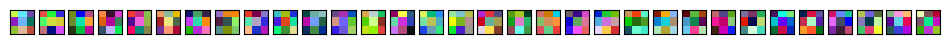

In [70]:
# Select the first Conv2D layer
conv_layer = model.layers[1]
filters, biases = conv_layer.get_weights()

# Normalize filter values to 0-1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 32  # Adjust n_filters to the number you want to visualize
figsize = (n_filters, 1) if n_filters <= 6 else (12, 12)

plt.figure(figsize=figsize)

for i in range(n_filters):
    # Get the filter
    f = filters[:, :, :, i]
    # Normalize filter values to 0-1 for visualization
    f_min, f_max = f.min(), f.max()
    f = (f - f_min) / (f_max - f_min)
    # Specify subplot and turn off axis
    ax = plt.subplot(1, n_filters, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    # Plot the filter as an RGB image
    plt.imshow(f)

# Show the figure
plt.show()

You can see that although in theory the idea of human interpretable features is nice....in practice often even well performing features are not easy interpretable by human beings.